In [1]:
from topologicpy.Vertex import Vertex
from topologicpy.Face import Face
from topologicpy.Cell import Cell
from topologicpy.CellComplex import CellComplex
from topologicpy.Cluster import Cluster
from topologicpy.Topology import Topology
from topologicpy.Dictionary import Dictionary
from topologicpy.Color import Color
from topologicpy.Plotly import Plotly
from topologicpy.Graph import Graph
from topologicpy.Vector import Vector

from topologicpy.Helper import Helper

In [2]:
def getSelectors(cell, keys, values):
    if not cell:
        return None
    # selectors = []
    s = Topology.InternalVertex(cell)
    d = Dictionary.ByKeysValues(keys, values)
    s = Topology.SetDictionary(s, d)
    # selectors.append(s)
    return s

def createPrism(dimension, location):
    w, l, h = dimension
    x, y, z = location
    prism = Cell.Prism(width=w, length=l, height=h, placement="lowerleft")
    prism = Topology.Translate(prism, x, y, z)
    return prism

def createAperture(room1, room2, is_full=True):
    names = [room1, room2]
    names_sel = []
    for sel in selectors:
        if sel.GetDictionary().ValueAtKey('title').StringValue() == room1:
            names_sel.append(sel)
    for sel in selectors:
        if sel.GetDictionary().ValueAtKey('title').StringValue() == room2:
            names_sel.append(sel)
    names_sel

    if not names_sel:
        return

    sub1 = Topology.SelectSubTopology(house, names_sel[0], subTopologyType="cell")
    sub2 = Topology.SelectSubTopology(house, names_sel[1], subTopologyType="cell")
    # print(f'{room1} has {len(Cell.Faces(sub1))} faces   |   {room2} has {len(Cell.Faces(sub2))} faces')
    shared = Topology.SharedFaces(sub1, sub2)
    aperture = Topology.Copy(shared[0])
    aperture = shared[0]
    # print(aperture)

    if is_full:
        return aperture
    else:
        bottom_edge = Face.Edges(aperture)[0]
        for edge in Face.Edges(aperture):
            if Topology.Centroid(edge).Z() < Topology.Centroid(bottom_edge).Z():
                bottom_edge = edge
            
        return Topology.Scale(aperture, x=0.5, z=0.8, origin=Topology.Centroid(bottom_edge))

def getCellFloorArea(cell):
    bottom_face = Cell.Faces(cell)[0]
    for face in Topology.SubTopologies(cell, subTopologyType="face"):
        if Topology.Centroid(face).Z() < Topology.Centroid(bottom_face).Z():
            bottom_face = face
        return Face.Area(bottom_face)

In [3]:
class Space():
    def __init__(self, name,label, dimension, location):
        self.name = name
        self.label = label
        self.dim = dimension
        self.w = dimension[0]
        self.l = dimension[1]
        self.h = dimension[2]
        self.loc = location
        self.x = location[0]
        self.y = location[1]
        self.z = location[2]
        self.topo = createPrism(dimension, location)
        self.selector = getSelectors(self.topo, ["label", "title", "area", "volume"], [self.label, self.name, getCellFloorArea(self.topo), Cell.Volume(self.topo)])
        

In [4]:
houses = []

In [142]:
x1 = 0
x2 = 6.5
x3 = 4

y1 = 0
y2 = 4
y3 = 4
y4 = 3.5

floor1 = 0
floor2 = 1.5
floor3 = 3

general_height = 3.0
wc_length = 1.3

corridor_width = 1.0
stairs_length = 1.8
# three_bedrooms = True


In [159]:
selectors = []
cells = []
apertures = []
keys = ["label", "title", "area", "volume"]

terrace = Space(
    "Terrace",
    6,
    [x3, y2, general_height],
    [x2, y1, floor1]
)

office = Space(
    "Office",
    10,
    [x3, y2, general_height],
    [x2 + corridor_width, y2, floor1] 
)

stairs1 = Space(
    "Stairs 1",
    2,
    [corridor_width, stairs_length, general_height + floor2], # TODO CHECK HEIGHT
    [x2, y2, floor1]
)

corridor1 = Space(
    "Corridor 1",
    3,
    [corridor_width, office.l - stairs1.l + wc_length, general_height],
    [x2, y2 + stairs1.l, floor2]
)

living = Space(
    "Living Room",
    1,
    [x2, y3, general_height],
    [x1, y2, floor2]
)

dining = Space(
    "Dining Room",
    4,
    [3, y4, general_height],
    [x1 + 0.5, y2+y3, floor2]
)

wc1 = Space(
    "WC 1",
    4,
    [x2 - dining.w - 0.5, wc_length, general_height ],
    [dining.x + dining.w, y2+y3, floor2]
)

kitchen = Space(
    "Kitchen",
    7,
    [x2 - dining.w - 0.5 + corridor_width, 3.0, general_height ],
    [dining.x + dining.w, y2+y3+wc1.l, floor2]
)

bedroom1 = Space(
    "Bedroom 1",
    10,
    [x3, y2, general_height],
    [x2 + corridor_width, y2, floor3] 
)

stairs2 = Space(
    "Stairs 2",
    2,
    [stairs_length, corridor_width, general_height + floor2], # TODO CHECK HEIGHT
    [x2 + corridor_width, y2+y3, floor2] 
)

service = Space(
    "Service",
    5,
    [corridor1.w, kitchen.l, general_height],
    [corridor1.x + corridor_width, kitchen.y, floor2]
)

house = Topology.Boolean(terrace.topo, office.topo, operation="merge")

cells.extend([
    terrace.topo,
    office.topo,
    stairs1.topo,
    corridor1.topo,
    living.topo,
    dining.topo,   
    wc1.topo,
    kitchen.topo,
    bedroom1.topo,  
    stairs2.topo,
    service.topo,
    # terrace.topo,  
    # wc2.topo,
    # living2.topo,
    # terrace2.topo,
    # bedroom2.topo,
    # wc3.topo,
])
selectors.extend([
    terrace.selector,
    office.selector,
    stairs1.selector,
    corridor1.selector,
    living.selector,
    dining.selector,
    wc1.selector,
    kitchen.selector,
    bedroom1.selector,    
    stairs2.selector,
    service.selector,
    # terrace.selector,    
    # wc2.selector,
    # living2.selector,
    # terrace2.selector,
    # bedroom2.selector,
    # wc3.selector,
])


# if three_bedrooms:
#     corridor2 = Space(
#         "Corridor 2",
#         3,
#         [corridor_width, stairs.l, general_height ],
#         [0, stairs.y, general_height]
#     )
    
#     bedroom3 = Space(
#         "Bedroom 3",
#         10,
#         [general_width, 5.0, general_height],
#         [0, 0, general_height]
#     )

#     wc4 = Space(
#         "WC 4",
#         4,
#         [(wc1.w + service.w), stairs.l, general_height ],
#         [(stairs.x + stairs.w), parking.l, general_height]
#     )

#     cells.extend([
#         corridor2.topo,
#         bedroom3.topo,
#         wc4.topo,
#     ])

#     selectors.extend([
#         corridor2.selector,
#         bedroom3.selector,
#         wc4.selector,
#     ])   



for cell in cells:    
    house = Topology.Boolean(house, cell, operation="merge")


In [165]:
aperture = createAperture("Terrace", "Office", False)
apertures.append(aperture)

aperture = createAperture("Terrace", "Stairs 1", True)
apertures.append(aperture)

aperture = createAperture("Stairs 1", "Corridor 1", True)
apertures.append(aperture)

aperture = createAperture("Corridor 1", "Living Room", True)
apertures.append(aperture)

aperture = createAperture("Corridor 1", "WC 1", False)
apertures.append(aperture)

aperture = createAperture("Corridor 1", "Kitchen", True)
apertures.append(aperture)

aperture = createAperture("Living Room", "Dining Room", True)
apertures.append(aperture)

aperture = createAperture("Dining Room", "Kitchen", True)
apertures.append(aperture)

aperture = createAperture("Kitchen", "Service",  False)
apertures.append(aperture)

aperture = createAperture("Corridor 1", "Stairs 2", True)
apertures.append(aperture)

aperture = createAperture("Stairs 2", "Bedroom 1",  True)
apertures.append(aperture)


In [166]:
selectors = Helper.Flatten(selectors)
cells = Helper.Flatten(cells)
house = CellComplex.ByCells(cells)
house = Topology.TransferDictionariesBySelectors(house, selectors, tranCells=True)
house = Topology.AddApertures(house, apertures, subTopologyType="face", exclusive=True)


Transfering Dictionaries to Cells


In [69]:
houses.append(house)
houses

 None,

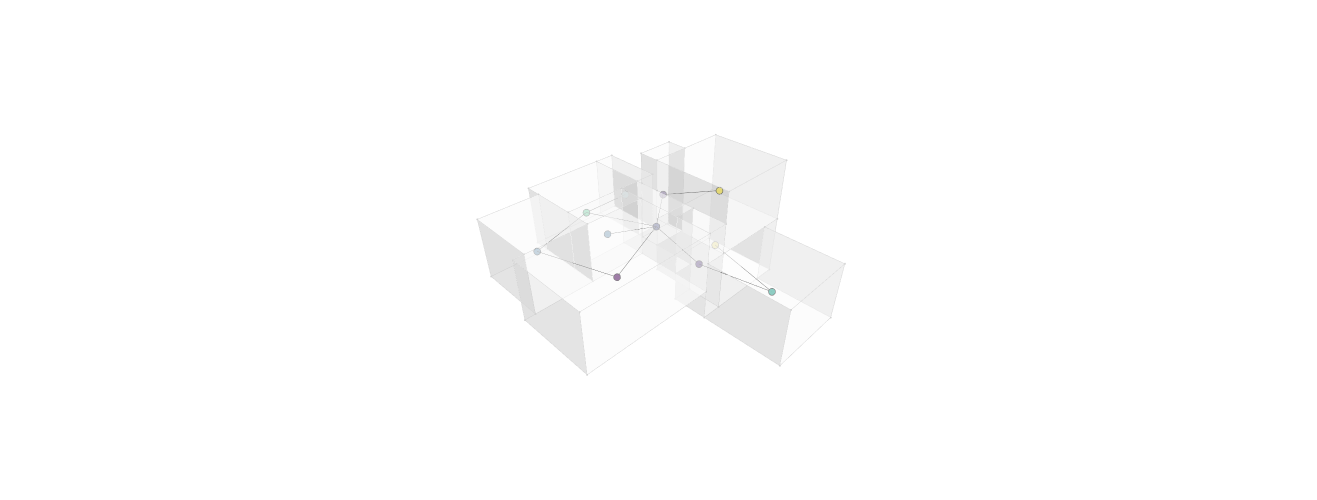

In [167]:
g = Graph.ByTopology(house, direct=False, directApertures=True)
graph_data = Plotly.DataByGraph(g, vertexSize=4, vertexGroupKey="label", vertexLabelKey="title", vertexGroups=[0,1,2,3,4,5,6,7,8,9,10])
bldg_data = Plotly.DataByTopology(house, faceOpacity=0.5, edgeColor="lightgrey", vertexColor="lightgrey")
# bldg_data = []
# graph_data = []
fig = Plotly.FigureByData(graph_data+bldg_data)
Plotly.Show(fig, renderer='jupyterlab')

In [ ]:
graphs

In [ ]:
Graph.ExportToCSV(graphs, "./data", 0, overwrite=True, nodeFeaturesKeys=['area', 'volume'], nodeFeaturesHeader=['area', 'volume'])

In [7]:
title = ["Backyard", "Service"]
selected_cell = []
for cell in Topology.SubTopologies(house, subTopologyType="cell"):
    if cell.GetDictionary().ValueAtKey("title").StringValue() in title:
        selected_cell.append(cell)
print(selected_cell)

AttributeError: 'NoneType' object has no attribute 'StringValue'

In [38]:
# Topology.Show(selected_cell, renderer='jupyterlab', showVertices=True, faceColor="#FFFFFF", backgroundColor="#777777")